In [6]:
import csv

import numpy as np
import tensorflow as tf
from sklearn import model_selection
import os

In [7]:
RANDOM_SEED = 42
NUM_CLASSES = 27
dataset = 'keypoint_classifier/keypoint_one_frame_model_all.csv'
model_save_path = 'keypoint_classifier/GRU_model_one_frame_aug.hdf5'

In [8]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [9]:

X_train = X_train[:, None, :]
print(X_train.shape)

(2271, 1, 42)


In [10]:
X_test = X_test[:, None, :]
print(X_test.shape)

(757, 1, 42)


In [11]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(1,42)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [12]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 50)             14100     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 gru_1 (GRU)                 (None, 100)               45600     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 27)                2727      
                                                                 
Total params: 62,427
Trainable params: 62,427
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
 1/15 [=>............................] - ETA: 33s - loss: 3.3001 - accuracy: 0.0391
Epoch 1: saving model to keypoint_classifier\GRU_model_one_frame_aug.hdf5
15/15 [==============================] - 3s 40ms/step - loss: 3.2812 - accuracy: 0.0628 - val_loss: 3.2581 - val_accuracy: 0.1011
Epoch 2/500
15/15 [==============================] - ETA: 0s - loss: 3.2308 - accuracy: 0.1195
Epoch 2: saving model to keypoint_classifier\GRU_model_one_frame_aug.hdf5
15/15 [==============================] - 0s 7ms/step - loss: 3.2308 - accuracy: 0.1195 - val_loss: 3.2126 - val_accuracy: 0.1209
Epoch 3/500
13/15 [=========================>....] - ETA: 0s - loss: 3.1740 - accuracy: 0.1382
Epoch 3: saving model to keypoint_classifier\GRU_model_one_frame_aug.hdf5
15/15 [==============================] - 0s 7ms/step - loss: 3.1705 - accuracy: 0.1393 - val_loss: 3.1397 - val_accuracy: 0.1363
Epoch 4/500
15/15 [==============================] - ETA: 0s - loss: 3.0726 - accuracy: 0.1685
Epoch 4: 

24/24 [==============================] - 0s 2ms/step


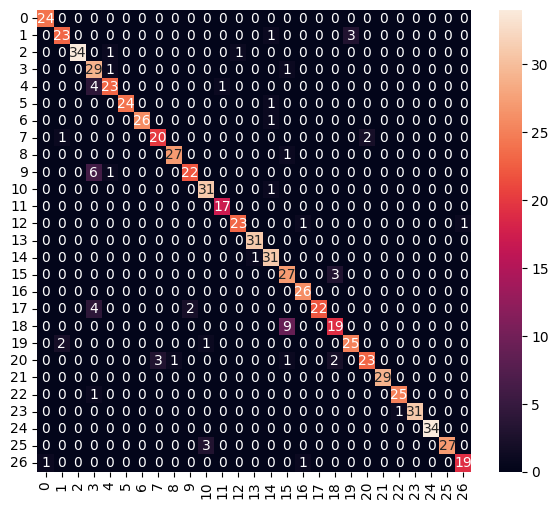

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       0.88      0.85      0.87        27
           2       1.00      0.94      0.97        36
           3       0.66      0.94      0.77        31
           4       0.88      0.82      0.85        28
           5       1.00      0.96      0.98        25
           6       1.00      0.96      0.98        27
           7       0.87      0.87      0.87        23
           8       0.96      0.96      0.96        28
           9       0.92      0.76      0.83        29
          10       0.89      0.97      0.93        32
          11       0.94      1.00      0.97        17
          12       0.96      0.92      0.94        25
          13       0.97      1.00      0.98        31
          14       0.89      0.97      0.93        32
          15       0.69      0.90      0.78        30
          16       0.93      1.00      0.96        26
     

In [14]:
# callback needs to be done better, but still accuracy 86%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [15]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      0.960     1.000     0.980        24
           1      0.885     0.852     0.868        27
           2      1.000     0.944     0.971        36
           3      0.659     0.935     0.773        31
           4      0.885     0.821     0.852        28
           5      1.000     0.960     0.980        25
           6      1.000     0.963     0.981        27
           7      0.870     0.870     0.870        23
           8      0.964     0.964     0.964        28
           9      0.917     0.759     0.830        29
          10      0.886     0.969     0.925        32
          11      0.944     1.000     0.971        17
          12      0.958     0.920     0.939        25
          13      0.969     1.000     0.984        31
          14      0.886     0.969     0.925        32
          15      0.692     0.900     0.783        30
          16      0.929     1.000     0.963        26
          17      1.000    

Text(0.5, 1.0, 'Loss')

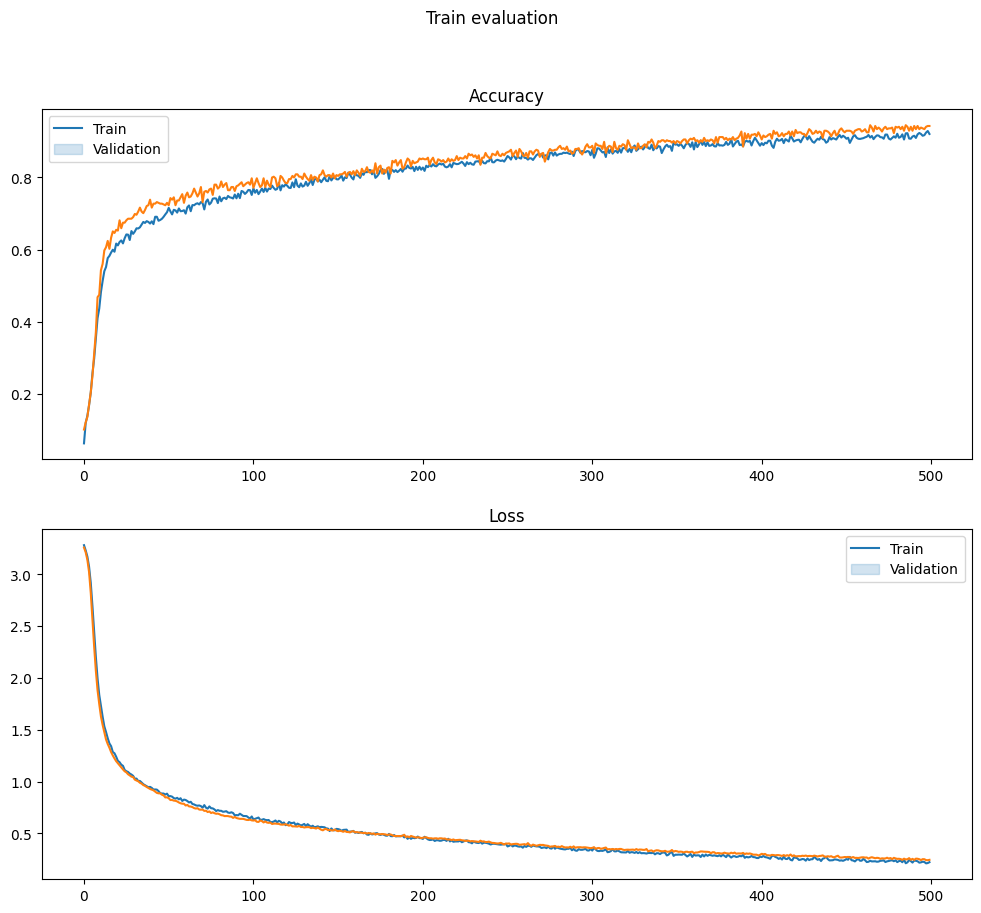

In [16]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [17]:
model_save_path = 'keypoint_classifier/LSTM_model_one_frame_aug.hdf5'
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1,2*21)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [18]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             18600     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                2727      
                                                                 
Total params: 81,727
Trainable params: 81,727
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
15/15 [==============================] - ETA: 0s - loss: 3.2903 - accuracy: 0.0793 
Epoch 1: saving model to keypoint_classifier\LSTM_model_one_frame_aug.hdf5
15/15 [==============================] - 3s 40ms/step - loss: 3.2903 - accuracy: 0.0793 - val_loss: 3.2852 - val_accuracy: 0.0725
Epoch 2/500
 1/15 [=>............................] - ETA: 0s - loss: 3.2805 - accuracy: 0.1016
Epoch 2: saving model to keypoint_classifier\LSTM_model_one_frame_aug.hdf5
15/15 [==============================] - 0s 6ms/step - loss: 3.2751 - accuracy: 0.0975 - val_loss: 3.2673 - val_accuracy: 0.0835
Epoch 3/500
 1/15 [=>............................] - ETA: 0s - loss: 3.2608 - accuracy: 0.1406
Epoch 3: saving model to keypoint_classifier\LSTM_model_one_frame_aug.hdf5
15/15 [==============================] - 0s 6ms/step - loss: 3.2457 - accuracy: 0.1041 - val_loss: 3.2292 - val_accuracy: 0.1033
Epoch 4/500
 1/15 [=>............................] - ETA: 0s - loss: 3.2248 - accuracy: 0.1016
Epoch 

24/24 [==============================] - 1s 1ms/step


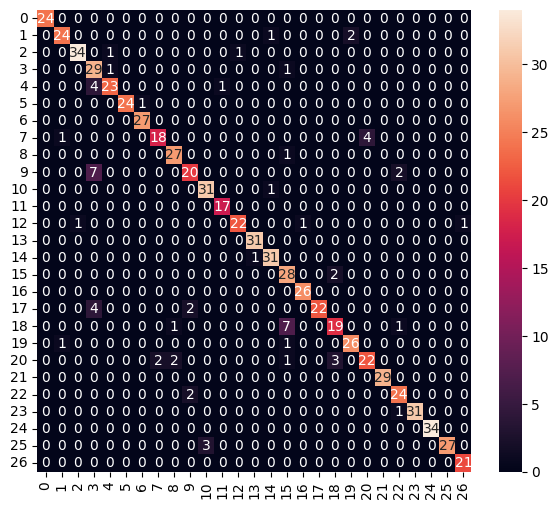

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.92      0.89      0.91        27
           2       0.97      0.94      0.96        36
           3       0.66      0.94      0.77        31
           4       0.92      0.82      0.87        28
           5       1.00      0.96      0.98        25
           6       0.96      1.00      0.98        27
           7       0.90      0.78      0.84        23
           8       0.90      0.96      0.93        28
           9       0.83      0.69      0.75        29
          10       0.91      0.97      0.94        32
          11       0.94      1.00      0.97        17
          12       0.96      0.88      0.92        25
          13       0.97      1.00      0.98        31
          14       0.94      0.97      0.95        32
          15       0.72      0.93      0.81        30
          16       0.96      1.00      0.98        26
     

In [20]:
# callback needs to be done better, but still accuracy 86%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [21]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        24
           1      0.923     0.889     0.906        27
           2      0.971     0.944     0.958        36
           3      0.659     0.935     0.773        31
           4      0.920     0.821     0.868        28
           5      1.000     0.960     0.980        25
           6      0.964     1.000     0.982        27
           7      0.900     0.783     0.837        23
           8      0.900     0.964     0.931        28
           9      0.833     0.690     0.755        29
          10      0.912     0.969     0.939        32
          11      0.944     1.000     0.971        17
          12      0.957     0.880     0.917        25
          13      0.969     1.000     0.984        31
          14      0.939     0.969     0.954        32
          15      0.718     0.933     0.812        30
          16      0.963     1.000     0.981        26
          17      1.000    

Text(0.5, 1.0, 'Loss')

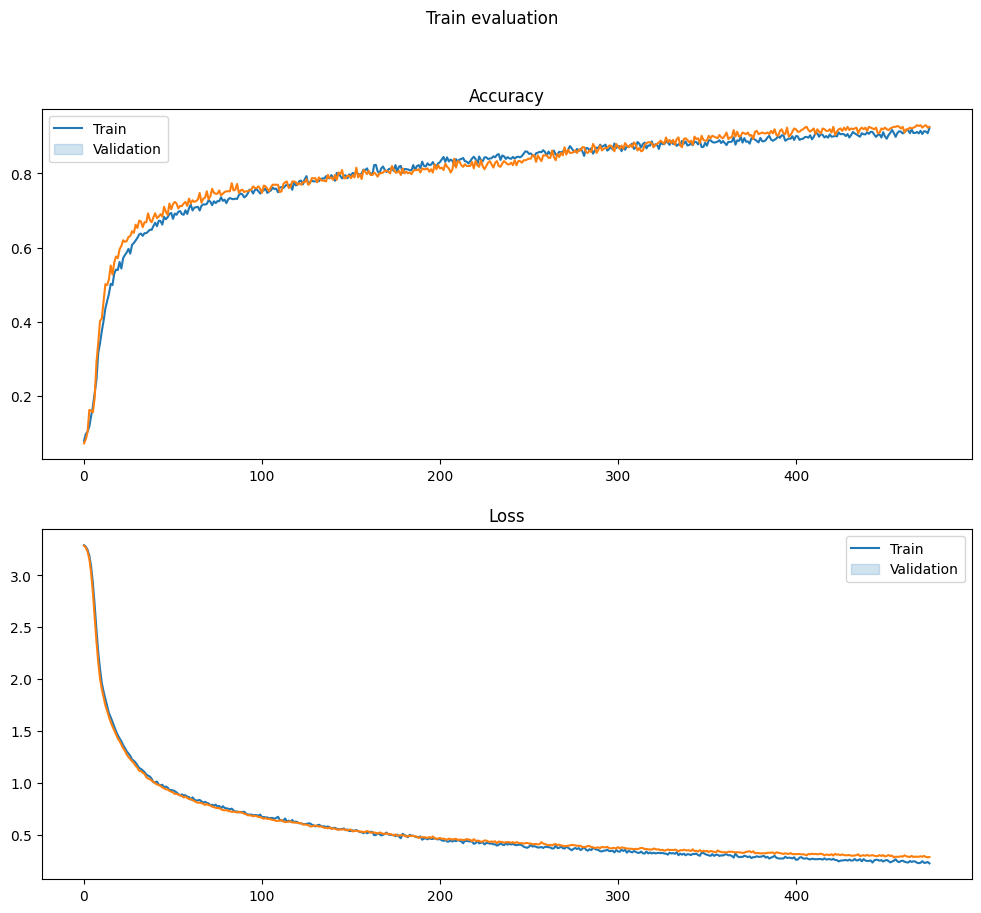

In [22]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [23]:
model_save_path = 'keypoint_classifier/SimpleRNN_model_one_frame_aug.hdf5'
from keras.layers import SimpleRNN
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(1,2*21)))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [24]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 50)             4650      
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               15100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 27)                2727      
                                                                 
Total params: 22,477
Trainable params: 22,477
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
 1/15 [=>............................] - ETA: 15s - loss: 3.4111 - accuracy: 0.0391
Epoch 1: saving model to keypoint_classifier\SimpleRNN_model_one_frame_aug.hdf5
15/15 [==============================] - 1s 21ms/step - loss: 3.3035 - accuracy: 0.0584 - val_loss: 3.1803 - val_accuracy: 0.1341
Epoch 2/500
 1/15 [=>............................] - ETA: 0s - loss: 3.1667 - accuracy: 0.0703
Epoch 2: saving model to keypoint_classifier\SimpleRNN_model_one_frame_aug.hdf5
15/15 [==============================] - 0s 5ms/step - loss: 3.1407 - accuracy: 0.0958 - val_loss: 3.0726 - val_accuracy: 0.1582
Epoch 3/500
 1/15 [=>............................] - ETA: 0s - loss: 3.1235 - accuracy: 0.1172
Epoch 3: saving model to keypoint_classifier\SimpleRNN_model_one_frame_aug.hdf5
15/15 [==============================] - 0s 5ms/step - loss: 3.0222 - accuracy: 0.1432 - val_loss: 2.9441 - val_accuracy: 0.2549
Epoch 4/500
 1/15 [=>............................] - ETA: 0s - loss: 2.9389 - accuracy

24/24 [==============================] - 0s 910us/step


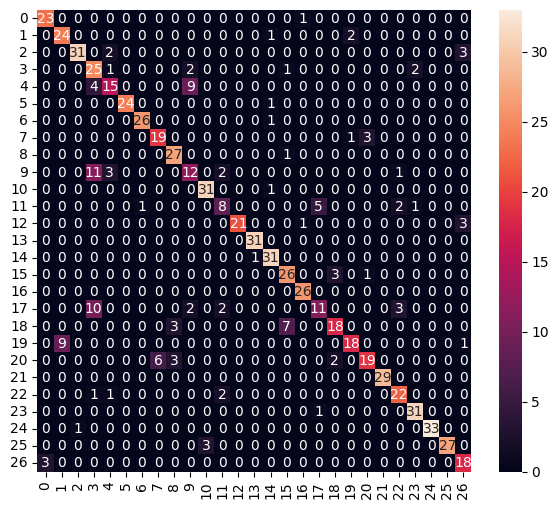

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        24
           1       0.73      0.89      0.80        27
           2       0.97      0.86      0.91        36
           3       0.49      0.81      0.61        31
           4       0.68      0.54      0.60        28
           5       1.00      0.96      0.98        25
           6       0.96      0.96      0.96        27
           7       0.76      0.83      0.79        23
           8       0.82      0.96      0.89        28
           9       0.48      0.41      0.44        29
          10       0.91      0.97      0.94        32
          11       0.57      0.47      0.52        17
          12       1.00      0.84      0.91        25
          13       0.97      1.00      0.98        31
          14       0.89      0.97      0.93        32
          15       0.74      0.87      0.80        30
          16       0.93      1.00      0.96        26
     

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [27]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      0.885     0.958     0.920        24
           1      0.727     0.889     0.800        27
           2      0.969     0.861     0.912        36
           3      0.490     0.806     0.610        31
           4      0.682     0.536     0.600        28
           5      1.000     0.960     0.980        25
           6      0.963     0.963     0.963        27
           7      0.760     0.826     0.792        23
           8      0.818     0.964     0.885        28
           9      0.480     0.414     0.444        29
          10      0.912     0.969     0.939        32
          11      0.571     0.471     0.516        17
          12      1.000     0.840     0.913        25
          13      0.969     1.000     0.984        31
          14      0.886     0.969     0.925        32
          15      0.743     0.867     0.800        30
          16      0.929     1.000     0.963        26
          17      0.647    

Text(0.5, 1.0, 'Loss')

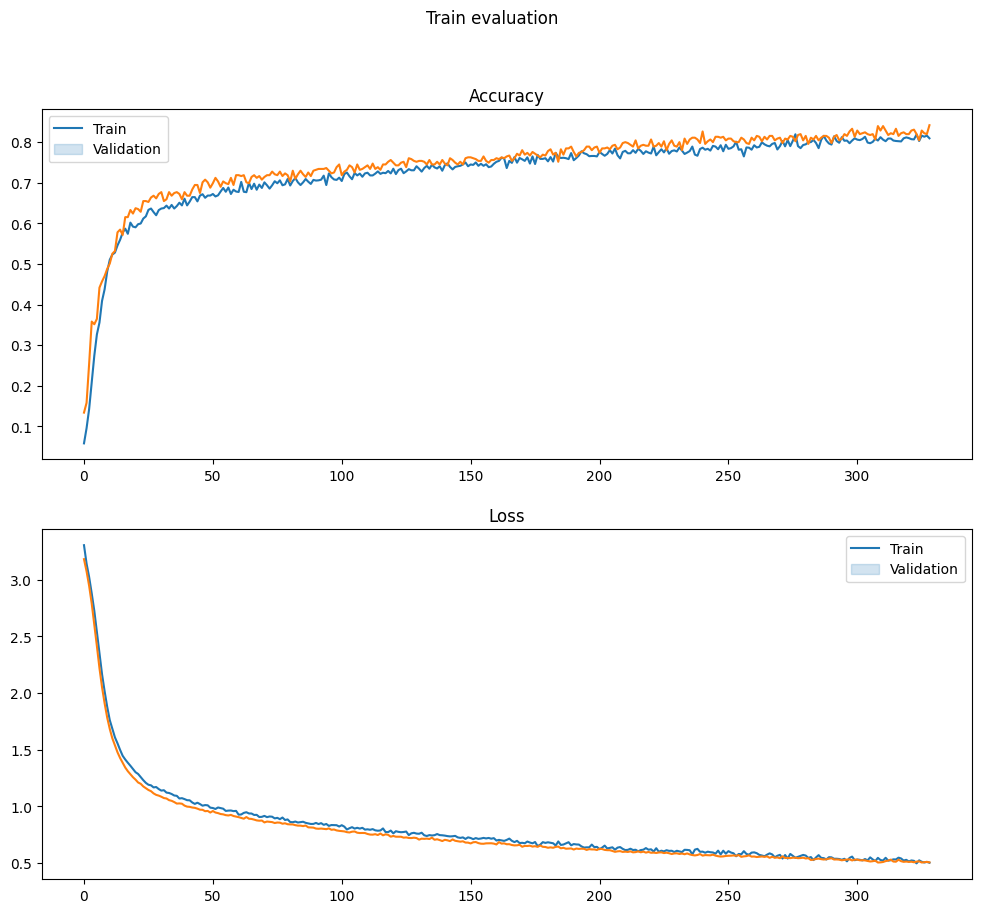

In [28]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [29]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [30]:
model_save_path = 'keypoint_classifier/FF_model_one_frame_aug.hdf5'
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import GRU
model = Sequential()
model.add(Dense(256, input_shape=(42,), activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               11008     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 27)                3483      
                                                                 
Total params: 47,387
Trainable params: 47,387
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
 1/15 [=>............................] - ETA: 5s - loss: 3.3046 - accuracy: 0.0312
Epoch 1: saving model to keypoint_classifier\FF_model_one_frame_aug.hdf5
15/15 [==============================] - 1s 11ms/step - loss: 3.1756 - accuracy: 0.1311 - val_loss: 3.0259 - val_accuracy: 0.1604
Epoch 2/500
 1/15 [=>............................] - ETA: 0s - loss: 3.0123 - accuracy: 0.1953
Epoch 2: saving model to keypoint_classifier\FF_model_one_frame_aug.hdf5
15/15 [==============================] - 0s 4ms/step - loss: 2.8832 - accuracy: 0.2059 - val_loss: 2.7611 - val_accuracy: 0.2110
Epoch 3/500
 1/15 [=>............................] - ETA: 0s - loss: 2.7159 - accuracy: 0.2734
Epoch 3: saving model to keypoint_classifier\FF_model_one_frame_aug.hdf5
15/15 [==============================] - 0s 4ms/step - loss: 2.6005 - accuracy: 0.2963 - val_loss: 2.4886 - val_accuracy: 0.2901
Epoch 4/500
 1/15 [=>............................] - ETA: 0s - loss: 2.3571 - accuracy: 0.3984
Epoch 4: savi

24/24 [==============================] - 0s 982us/step


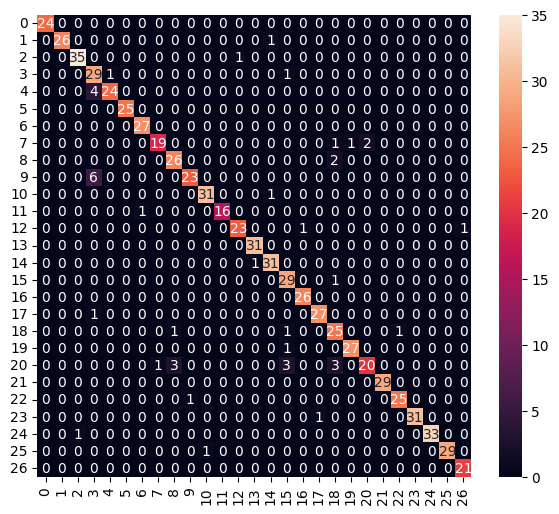

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      0.96      0.98        27
           2       0.97      0.97      0.97        36
           3       0.72      0.94      0.82        31
           4       0.96      0.86      0.91        28
           5       1.00      1.00      1.00        25
           6       0.96      1.00      0.98        27
           7       0.95      0.83      0.88        23
           8       0.87      0.93      0.90        28
           9       0.96      0.79      0.87        29
          10       0.97      0.97      0.97        32
          11       1.00      0.94      0.97        17
          12       0.96      0.92      0.94        25
          13       0.97      1.00      0.98        31
          14       0.94      0.97      0.95        32
          15       0.83      0.97      0.89        30
          16       0.96      1.00      0.98        26
     

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [33]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        24
           1      1.000     0.963     0.981        27
           2      0.972     0.972     0.972        36
           3      0.725     0.935     0.817        31
           4      0.960     0.857     0.906        28
           5      1.000     1.000     1.000        25
           6      0.964     1.000     0.982        27
           7      0.950     0.826     0.884        23
           8      0.867     0.929     0.897        28
           9      0.958     0.793     0.868        29
          10      0.969     0.969     0.969        32
          11      1.000     0.941     0.970        17
          12      0.958     0.920     0.939        25
          13      0.969     1.000     0.984        31
          14      0.939     0.969     0.954        32
          15      0.829     0.967     0.892        30
          16      0.963     1.000     0.981        26
          17      0.964    

Text(0.5, 1.0, 'Loss')

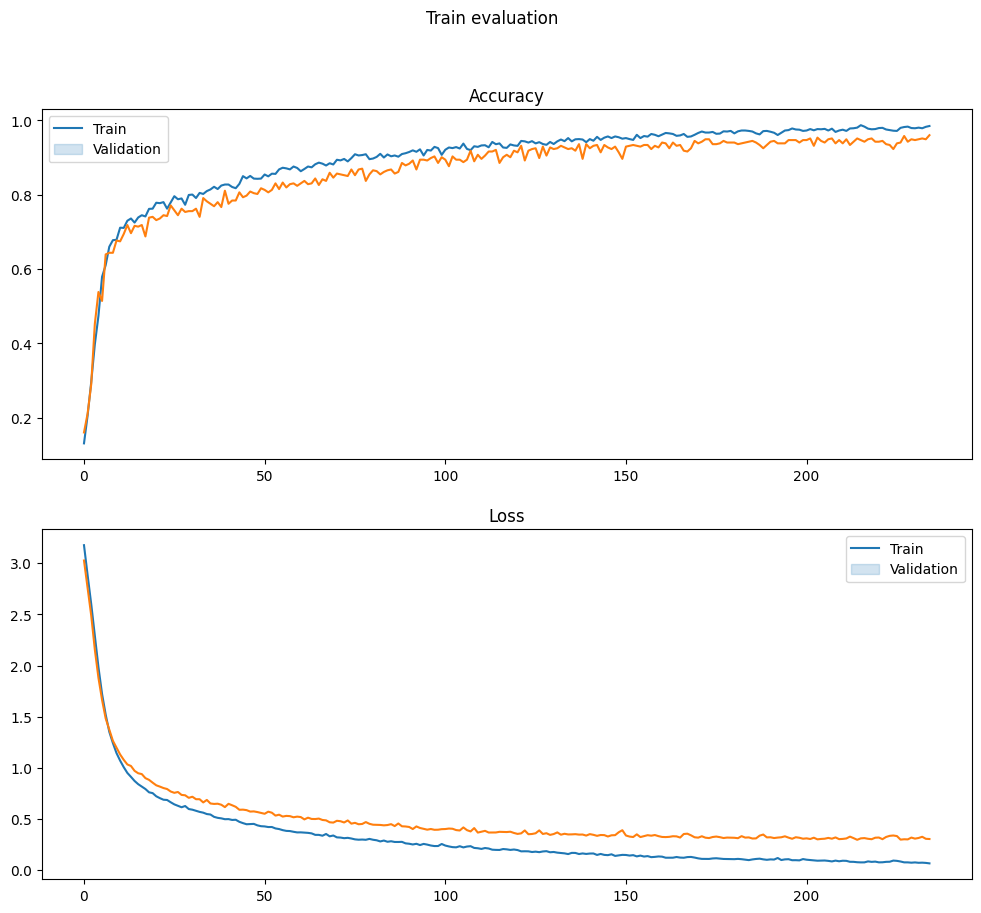

In [34]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them